[[1]]
 [1] "msm"        "plotly"     "tools"      "dplyr"      "data.table"
 [6] "ggplot2"    "stats"      "graphics"   "grDevices"  "utils"     
[11] "datasets"   "methods"    "base"      

[[2]]
 [1] "msm"        "plotly"     "tools"      "dplyr"      "data.table"
 [6] "ggplot2"    "stats"      "graphics"   "grDevices"  "utils"     
[11] "datasets"   "methods"    "base"      

[[3]]
 [1] "msm"        "plotly"     "tools"      "dplyr"      "data.table"
 [6] "ggplot2"    "stats"      "graphics"   "grDevices"  "utils"     
[11] "datasets"   "methods"    "base"      

[[4]]
 [1] "msm"        "plotly"     "tools"      "dplyr"      "data.table"
 [6] "ggplot2"    "stats"      "graphics"   "grDevices"  "utils"     
[11] "datasets"   "methods"    "base"      

[[5]]
 [1] "msm"        "plotly"     "tools"      "dplyr"      "data.table"
 [6] "ggplot2"    "stats"      "graphics"   "grDevices"  "utils"     
[11] "datasets"   "methods"    "base"

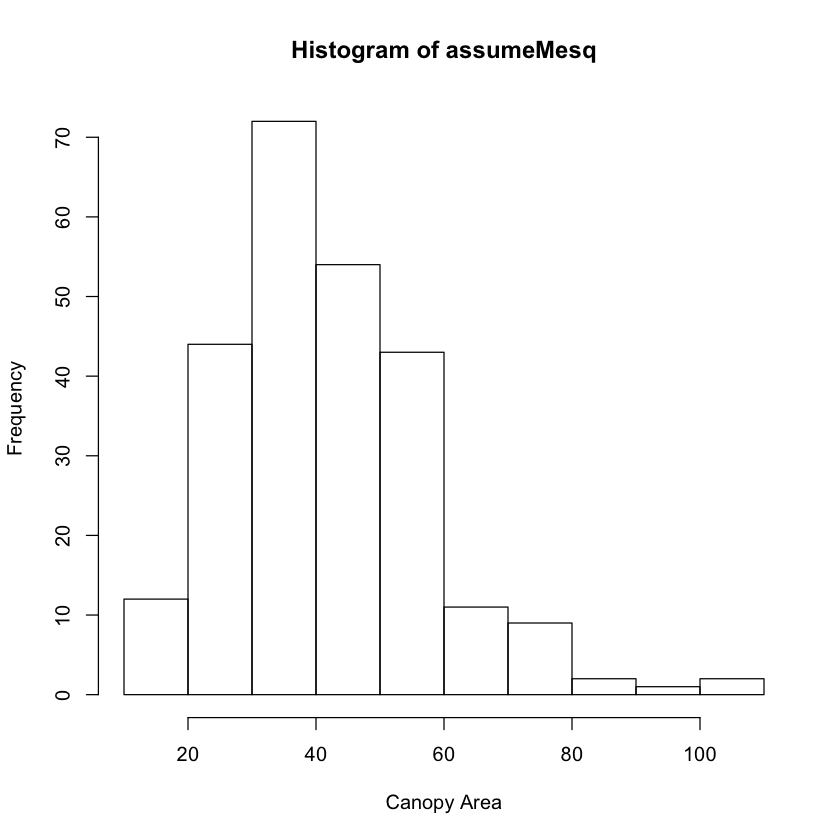

In [11]:
#This script describes what biomass density would be predicted from a model that only knows canopy area and, specificaly, does not know species
#In development of a model to estimate biomass from Structure from Motion Point Clouds
#Specifically, I am trying to answer the question: do we need to know the species of individaul plants, or can we account for diversity with species-mixture parameters?
#Load packages:
packages = c('ggplot2', 'data.table', 'dplyr', 'tools', 'plotly')
lapply(packages, library, character.only = TRUE)

#allometric models:
#Cercidium microphyllum (paloverde canopy area allometry-biomass not published?)
#natural log
#log(Y) = (a + b(log(X)))*CF
#Mesquite (Prosopis velutina) biomass - canopy area relationship:
mesqAllom <- function(X){
  #Function takes in Canopy Area (CA) in square meters or vector of CAs and returns Total biomass (kg) of mesquite
  #Equation from McClaran et al. 2013
  a = -.59
  b = 1.60
  CF = 1.06
  biomass <- exp(a + b*(log(X))*CF)
  return(biomass)

}

#hackberry (Celtis pallida)
hackAllom <- function(X){
  #Function takes in Canopy Area (CA) in square meters or vector of CAs and returns Total biomass (kg)
  #From HUANG et al. 2007
  #to return mass in kg, multiply by .001
  biomass <- .001*exp(1.02*(6.78 + 1.41 * log(X)))
  return(biomass)
}

#Burrowweed
#As scripted, this function returns funny values
burrAllom <- function(X){
   biomass<-.001*exp(4.81 + 1.25 *log(X*(1/10000)))
   return(biomass)
}


# Prickly pear (Opuntia engelmannii)
#r 1⁄4 ([center height/2] þ [longest diameter/2])/2, where center height and longest diameter are measured in METERS IN THIS IMPLEMENTATION
prickAllom <- function(r){  
  #Convert input METERS to centimeters:
  r <- r * 100
  biomass <-((4.189 * r^3)^0.965)/(10^5)
  return(biomass)
}  





# But now to the important part
# let's graph how much biomass DENSITY varies if we assume certain species mixtures:
# i.e. what is the estimated biomass density of a hectare of land if assume it as all mesquite vs all hackberry vs some species mixture
# The goal being to see IF the species classification matters when predicting biomass from a common feature such as canopy area or height)
#First we'll assume a number of plants in a given area in hectares
numPlants <- 250
area <- 1

#Then, we assume some species mixing parameters:
#PROPORTIONS ARE BY NUMBERS OF SPECIES
#Prosopis velutina:
pMesquite <- .6

#Celtis pallida:
pHackberry <- .2

#Isocoma tenuisecta: (don't know if this is present at our site)
#pBurroweed <- .025

#Opuntia engelmannii 
pPricklypear <- .2

#Cercidium microphyllum (don't know if this is present at our site nor do I have allometry-biomass relationship for it)
#pPaloverde <- .025



#now generate different mass estimates assuming ONE allometric equation
assumeMesq<-mesqAllom(DT[,CA])
hist(assumeMesq, xlab = "Canopy Area")

In [ ]:
assumeHack<-hackAllom(DT[,CA])
hist(assumeHack)

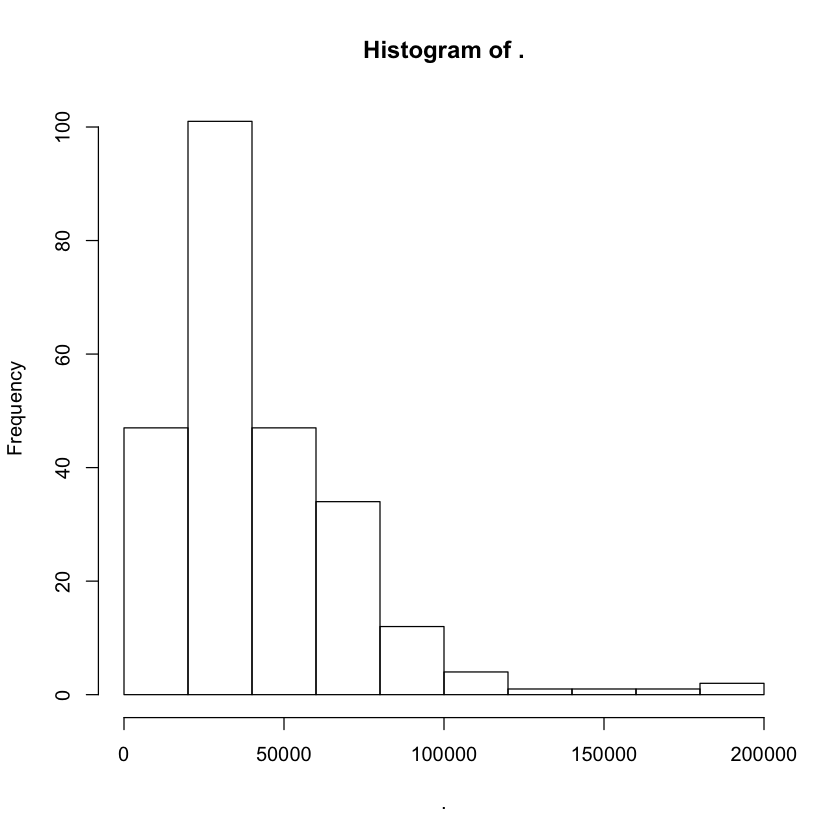

In [8]:
assumePrick <- prickAllom(DT[,CA]) %>% hist()

Notice that piping the data into the call of hist() doesn't transfer the name of the object into the title.

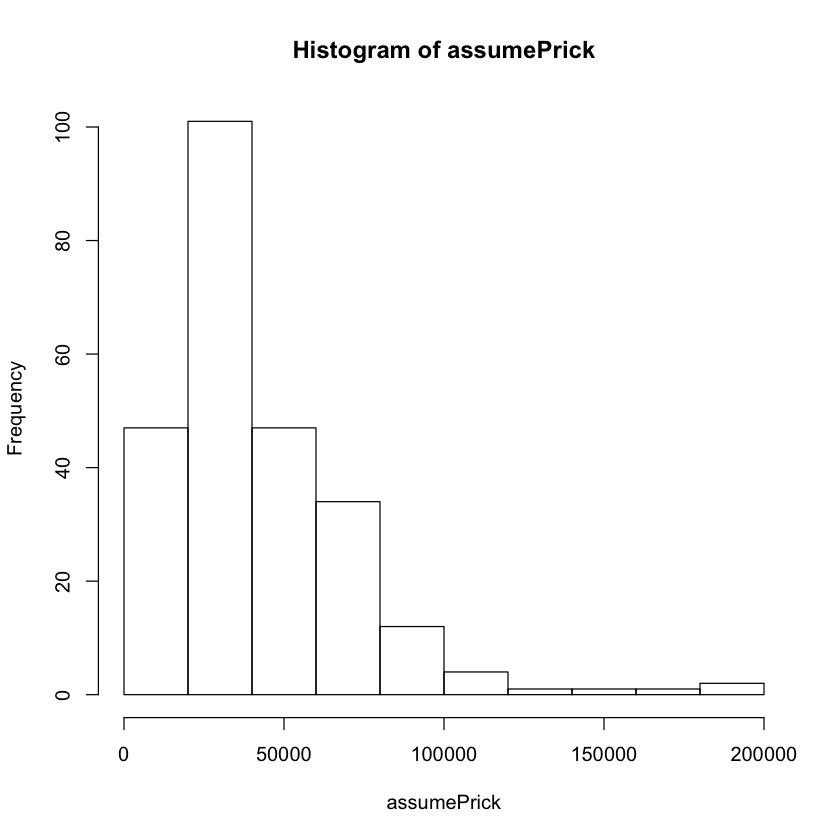

In [10]:
assumePrick<-prickAllom(DT[,CA])
hist(assumePrick)

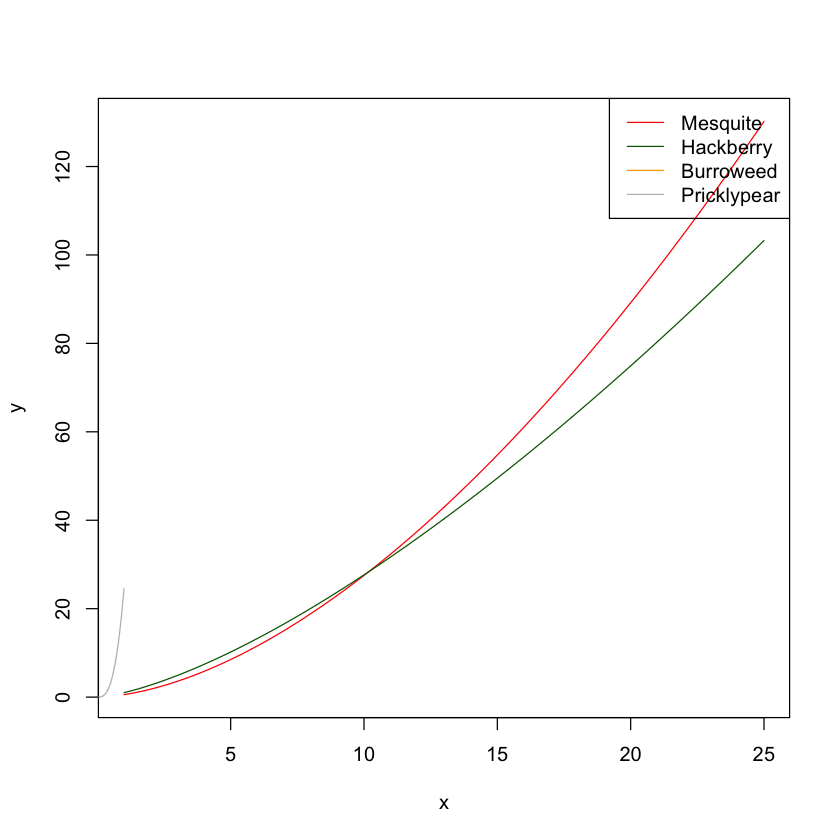

In [3]:
#Plot lines biomass over canopy area:
x <- seq(from = 1, to = 25, length.out = 1000)
y <- mesqAllom(x)
yHack<- hackAllom(x)
yBurr <- burrAllom(x)

xPrick <- seq(from = 0 , to = 1., length.out = 1000)
yPrick <- prickAllom(xPrick)plot(x,y, type = "l", col = "red")
lines(x,yHack, col = "darkgreen")
#lines(x,yBurr, col = "orange")
lines(xPrick,yPrick, col = "grey")
legend("topright", c("Mesquite", "Hackberry", "Burroweed", "Pricklypear"), col=c("red", "darkgreen", "orange", "grey"), title = NULL, lty = 1)


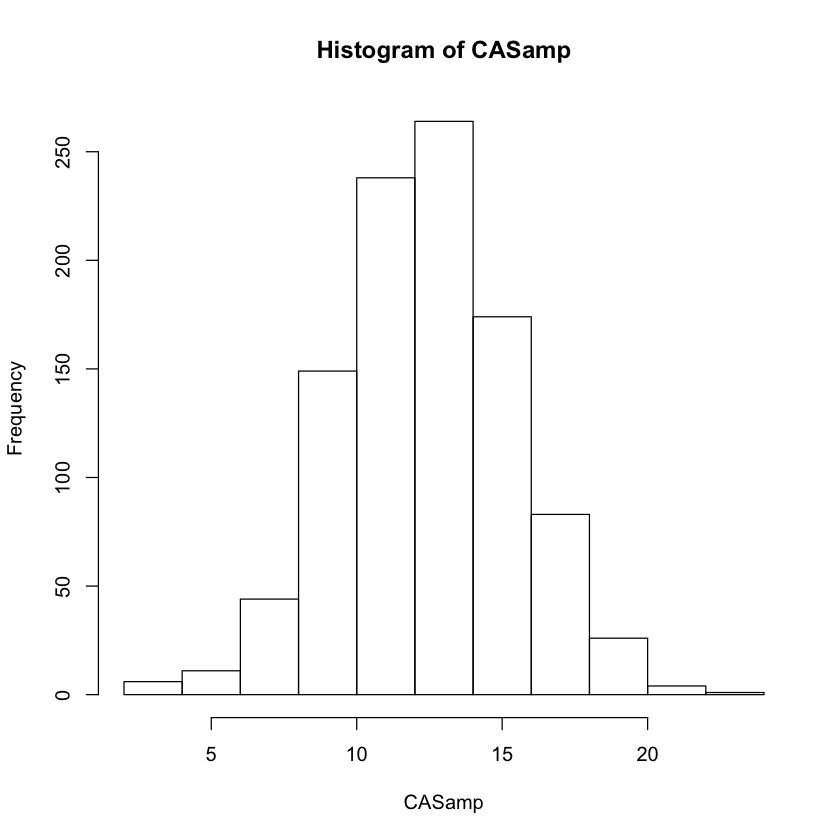

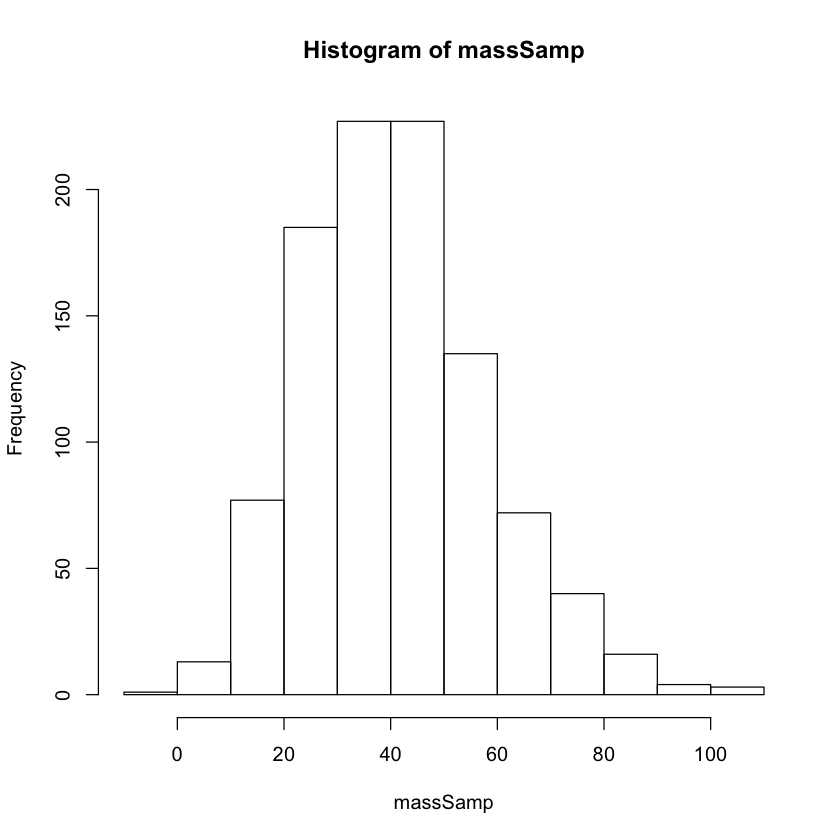

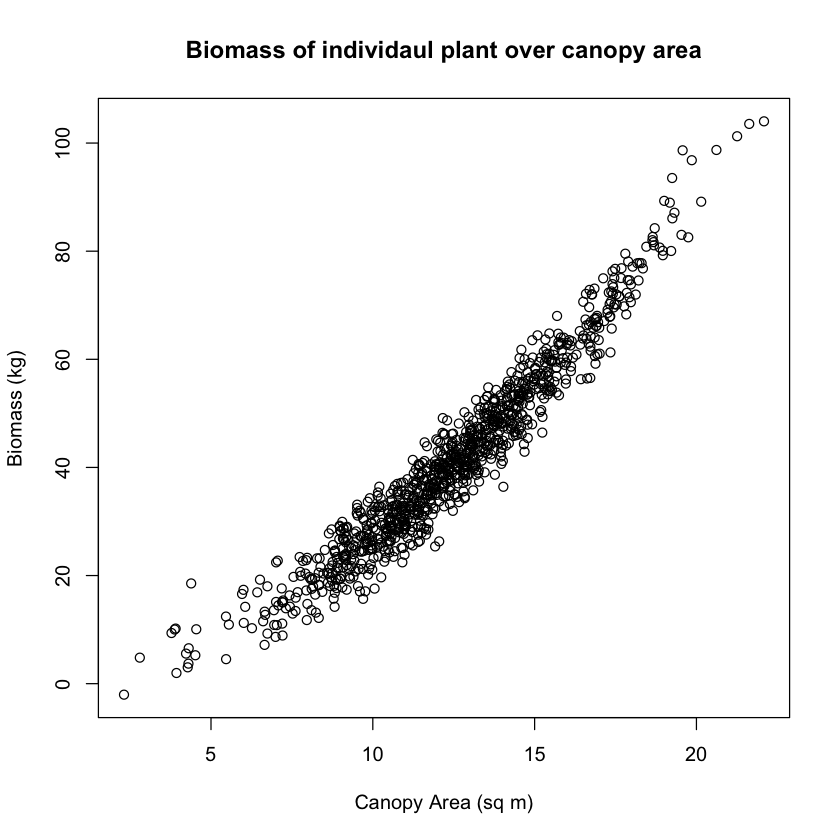

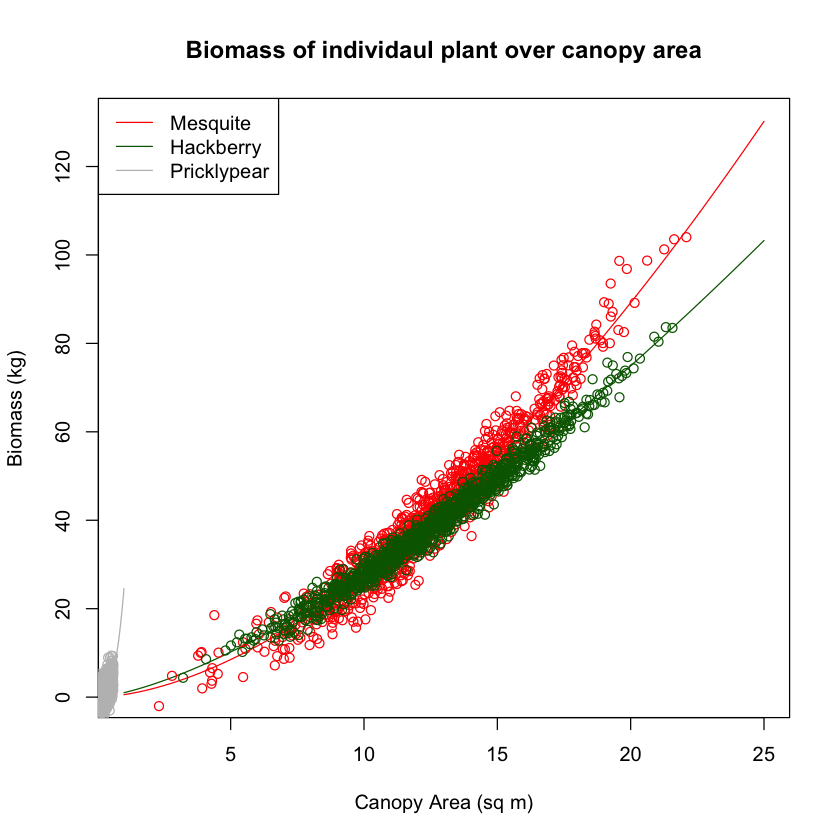

In [4]:
#Now let's sample from an assumed Gaussian distribution (the assumption we will verify later with data):
# I use here a truncated Guassian, to represent that we don't find infinitely large plants or plants that have negative dimensions:
library(msm)
set.seed(1234)
n <- 1000
CASamp <- rtnorm(n, 12.5, 3, lower = 0, upper = 25)
hist(CASamp)
#Gaussian varation in mass, for the time being
massSamp <- mesqAllom(CASamp) + rnorm(n, 0, 4)
hist(massSamp)
CASampHack <- rtnorm(n, 12.5, 3, lower = 0, upper = 25)
massSampHack <- hackAllom(CASampHack) + rnorm(n, 0, 2)
rSampPrick <- rtnorm(n, .3, 2, lower = 0, upper = .6)
massSampPrick <- prickAllom(rSampPrick) + rnorm(n, 0, 2)





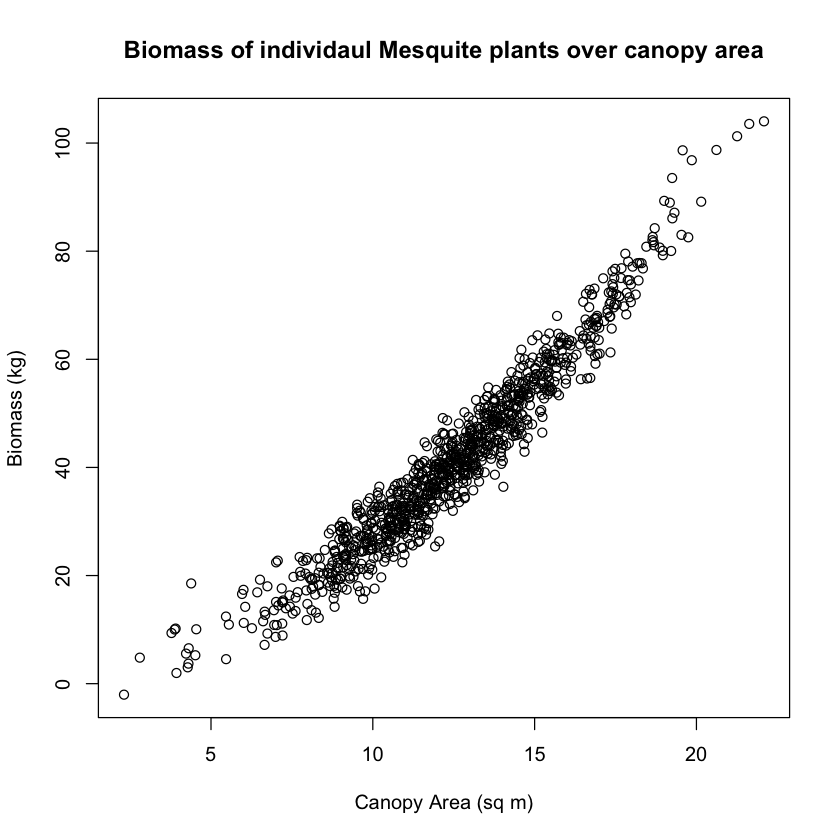

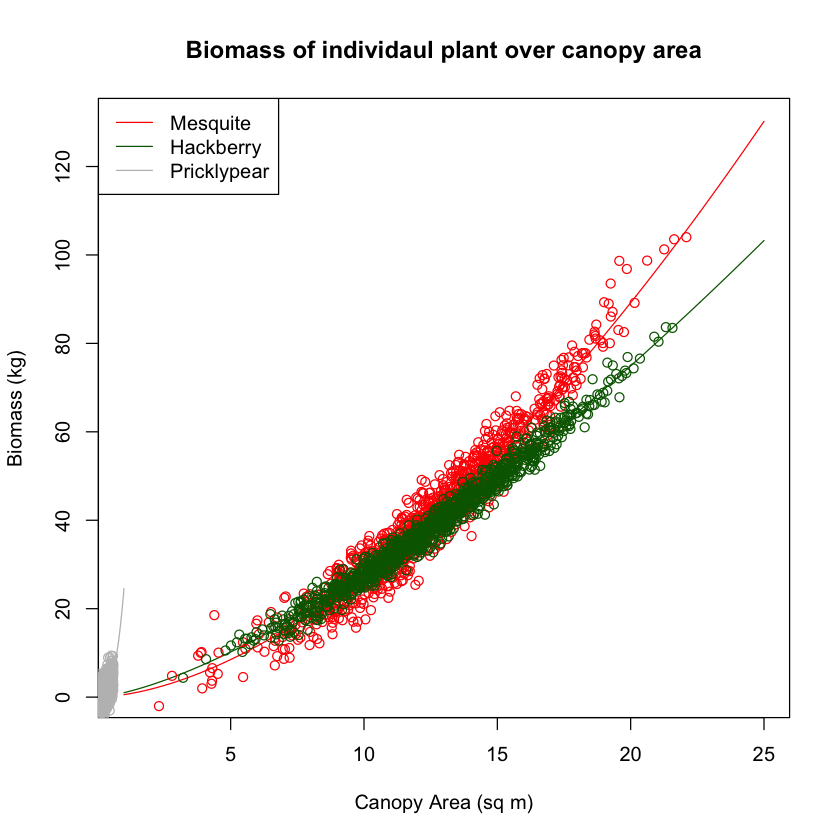

In [6]:

#Visualize
plot(CASamp, massSamp, xlab = "Canopy Area (sq m)", ylab = "Biomass (kg)", main = "Biomass of individaul Mesquite plants over canopy area")
plot(x,y, type = "l", col = "red", xlab = "Canopy Area (sq m)", ylab = "Biomass (kg)", main = "Biomass of individaul plant over canopy area")
lines(x,yHack, col = "darkgreen")
lines(xPrick,yPrick, col = "grey")
points(CASamp, massSamp, col = "red")
points(CASampHack, massSampHack, col = "darkgreen")
points(rSampPrick, massSampPrick, col = "grey")
legend("topleft", c("Mesquite", "Hackberry", "Pricklypear"), col=c("red", "darkgreen", "grey"), title = NULL, lty = 1)

In [ ]:
#now we sample canopy areas from this distribution:
mesquites <- sample(CASamp, numPlants * pMesquite)
mesquites <- as.data.table(mesquites)
mesquites[,mass := mesqAllom(mesquites)]
colnames(mesquites) <- c("CA", "mass")
mesquites[,species:="mesquite"]

hackberries <- sample(CASampHack, numPlants * pHackberry)
hackberries <- as.data.table(hackberries)
hackberries[,mass:= hackAllom(hackberries)]
colnames(hackberries) <- c("CA", "mass")
hackberries[,species:="hackberry"]

pricklypears <- sample(CASampHack, numPlants * pPricklypear)
pricklypears <- as.data.table(pricklypears)
pricklypears[,mass:= prickAllom(pricklypears)]
colnames(pricklypears) <- c("CA", "mass")
pricklypears[,species:="pricklypear"]

DT = rbindlist(list(mesquites, hackberries, pricklypears))